**Full Name:** Alireza Sabounchi

**St ID:** 401212454


In this assignment, we will be creating and training a neural network to generate captions for images using the [MS-COCO dataset](https://cocodataset.org/#home). Image captioning is a task that requires techniques from both computer vision and natural language processing. The COCO dataset is a large-scale object detection, segmentation, and captioning dataset that will be used to train our model. Our neural network architecture will consist of both convolutional neural networks (CNNs) and recurrent nural networks (RNNs) to automatically generate captions from images. We will be using an Encoder-Decoder architecture that combines the outputs of an image classification CNN (resnet, inception, ... ) and an RNN model (GRU, LSTM) to produce the relevant caption. The accuracy of our model will be evaluated using widely used evaluation metrics in the image captioning field such as BLEU and Perplexity metrics.

To simplify the process, we will use a pre-trained model for the vision part using transfer learning technique. Transfer learning is a popular method in computer vision that allows us to build accurate models in a time-saving way by starting from patterns that have been learned when solving a different problem. A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. We can either use the pre-trained model as is or use transfer learning to customize this model to our given task.

Notes:
* To complete the assignment, you must only work on the sections that are commented with `"======== TODO ========"` and should not change other parts of the notebook.

* Each class, function or cell code in the assignment has a guide that explains it. We believe that these explanations are sufficient to complete the task. However, if you have any questions, you can ask them in the `assignments section of the Quera course`.

* For each step, first determine what you want to accomplish and then write the necessary code to achieve it.


## Preliminares

To begin with the assignment, we will need to install the required packages, download the dataset, and perform some preparation tasks for the next parts.

### Install and import required packages

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 26.5 MB/s eta 0:00:00


In [2]:
import os
import torch
import nltk
import pandas as pd
import numpy as np
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from tqdm.auto import tqdm
from PIL import Image

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Download the COCO dataset

In [3]:
# Download train2017.zip, annotations_trainval2017.zip , val2017.zip and test2017.zip
os.system('wget http://images.cocodataset.org/annotations/image_info_test2017.zip')
os.system('wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip')
os.system('wget http://images.cocodataset.org/zips/train2017.zip')
os.system('wget http://images.cocodataset.org/zips/val2017.zip')
# os.system('wget http://images.cocodataset.org/zips/test2017.zip')

# # Unzip the downloaded files
os.system('unzip annotations_trainval2017.zip')
os.system('unzip image_info_test2017.zip')
os.system('unzip train2017.zip')
os.system('unzip val2017.zip')
# os.system('unzip test2017.zip')

# # Remove the zip files
os.system('rm annotations_trainval2017.zip')
os.system('rm image_info_test2017.zip')
os.system('rm train2017.zip')
os.system('rm val2017.zip')
# os.system('rm test2017.zip')

0

### Prepare dataset

In the below cell, we will read COCO dataset annotation files and create a pandas dataframe that maps each image ID to its related caption. After running this cell, there will be saved CSV files named `*_captions.csv` for the train, validation, and test sets.

In [4]:
import json

# paths of the json files
json_paths = [
    ('/content/annotations/captions_train2017.json', '/content/train_captions.csv'),
    ('/content/annotations/captions_val2017.json', '/content/val_captions.csv'),
    ('/content/annotations/image_info_test2017.json', '/content/test_captions.csv')
  ]

for path in json_paths:
    # Open the JSON file containing image annotations and load the content into a dictionary
    with open(path[0]) as file:
        annotations = json.load(file)

    if annotations.get('annotations'):
            # Create a dictionary to map image file names to their corresponding image IDs
        file_name_to_id = {}
        for image in annotations['images']:
            file_name_to_id[image['file_name']] = image['id']
    else:
        file_name_to_id = {}
        for image in annotations['images']:
            file_name_to_id[image['file_name']] = image['coco_url']


    if annotations.get('annotations'):
        # Create a dictionary to map image IDs to their corresponding captions
        id_to_caption = {}
        for annotation in annotations['annotations']:
            id_to_caption[annotation['image_id']] = annotation['caption']
        # Map the id_to_caption dictionary to the file_name_to_id dictionary
        for key in file_name_to_id.keys():
            file_name_to_id[key] = id_to_caption[file_name_to_id[key]]
        # Use the Pandas library to create a new dataframe with columns named 'image' and 'caption'
        data_frame = pd.DataFrame(columns=['image','caption'])

    data_frame = pd.DataFrame(columns=['image','caption'])
    data_frame['image'] = file_name_to_id.keys()
    data_frame['caption'] = file_name_to_id.values()
    # Write the dataframe to a CSV file
    data_frame.to_csv(path[1], index=False)

Next, we load the saved data frames and update the `image` column with the correct addresses of the image files. Since there is no caption for the test set, we utilized the download URL from COCO and placed it in the caption column. This will be used in the Dataset class in the next section.

In [5]:
# Load the training captions dataframe
train_df = pd.read_csv('train_captions.csv')

# Load the validation captions dataframe
val_df = pd.read_csv('val_captions.csv')

# Load the test captions dataframe
test_df = pd.read_csv('test_captions.csv')

# Update the 'image' column in the training dataframe with the correct addresses of the image files
train_df['image'] = train_df['image'].apply(lambda x: '/content/train2017/' + x)

# Update the 'image' column in the validation dataframe with the correct addresses of the image files
val_df['image'] = val_df['image'].apply(lambda x: '/content/val2017/' + x)

# Continue working with the updated training dataframe
train_df

,image,caption
0,/content/train2017/000000391895.jpg,A man in a red shirt and a red hat is on a mot...
1,/content/train2017/000000522418.jpg,A woman marking a cake with the back of a chef...
2,/content/train2017/000000184613.jpg,A boy holding an umbrella while standing next ...
3,/content/train2017/000000318219.jpg,a young kid with head phones on using a computer
4,/content/train2017/000000554625.jpg,A small child wearing headphones plays on the ...
...,...,...
118282,/content/train2017/000000444010.jpg,A jovial older couple and a young woman enjoy...
118283,/content/train2017/000000565004.jpg,A wine glass being filled with red wine.
118284,/content/train2017/000000516168.jpg,A man is sitting at a table with papers and wi...
118285,/content/train2017/000000547503.jpg,Old couple is sitting at the bar with wine gla...


In [6]:
test_df

,image,caption
0,000000466319.jpg,http://images.cocodataset.org/test2017/0000004...
1,000000523573.jpg,http://images.cocodataset.org/test2017/0000005...
2,000000308929.jpg,http://images.cocodataset.org/test2017/0000003...
3,000000057540.jpg,http://images.cocodataset.org/test2017/0000000...
4,000000579853.jpg,http://images.cocodataset.org/test2017/0000005...
...,...,...
40665,000000361178.jpg,http://images.cocodataset.org/test2017/0000003...
40666,000000208495.jpg,http://images.cocodataset.org/test2017/0000002...
40667,000000204154.jpg,http://images.cocodataset.org/test2017/0000002...
40668,000000206086.jpg,http://images.cocodataset.org/test2017/0000002...


### Create Vocabulary
In NLP tasks, we need to have a vocabulary that holds all available tokens of the language or dataset, and this vocabulary is used to convert words to integer IDs and vice versa(why we need to IDs?). The below cell creates a vocabulary class that is used to creates a vocabulary for a text corpus, It also saves the vocabulary in a pickle file for future usage.

In [7]:
import pickle
from collections import Counter
from nltk.tokenize import word_tokenize

class Vocabulary(object):
    def __init__(self, texts, unk_cutoff=3, vocab_file='./vocabulary.pkl',
                 start_token="<START>", end_token="<END>",
                 unk_token="<UNK>", pad_token="<PAD>"):
        """
        Initializes a Vocabulary object.

        Parameters:
            texts (list): A list of texts or captions used to build the vocabulary.
            unk_cutoff (int, optional): The minimum count threshold for a word to be included in the vocabulary. Defaults to 3.
            vocab_file (str, optional): The file path to save or load the vocabulary. Defaults to './vocabulary.pkl'.
            start_token (str, optional): The token to represent the start of a sequence. Defaults to "<START>".
            end_token (str, optional): The token to represent the end of a sequence. Defaults to "<END>".
            unk_token (str, optional): The token to represent unknown words. Defaults to "<UNK>".
            pad_token (str, optional): The token to represent padding. Defaults to "<PAD>".
        """
        self.texts = texts
        self.unk_cutoff = unk_cutoff
        self.vocab_file = vocab_file
        self.start_token = start_token
        self.end_token = end_token
        self.unk_token = unk_token
        self.pad_token = pad_token
        self._get_vocab()

    def _get_vocab(self):
        # Load vocabulary if it already exists
        if os.path.exists(self.vocab_file):
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print(f'Vocabulary successfully loaded from {self.vocab_file} file!')
        else:
            self._build_vocab()
            # Save the vocabulary to a file
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)

    def _build_vocab(self):
        # Initialize the vocabulary
        self._init_vocab()
        # Add special tokens
        self._add_word(self.pad_token)
        self._add_word(self.start_token)
        self._add_word(self.end_token)
        self._add_word(self.unk_token)
        # Add words from the texts
        self._add_captions()

    def _init_vocab(self):
        # Initialize word-to-index and index-to-word mappings
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def _add_word(self, word):
        # Add a word to the vocabulary if it doesn't exist
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def _add_captions(self):
        counter = Counter()
        for i, caption in enumerate(self.texts):
            # Tokenize captions into words
            tokens = word_tokenize(caption.lower())
            # Update word counts
            counter.update(tokens)

            if i % 10000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(self.texts)))

        # Add words to the vocabulary based on their counts
        words = [word for word, cnt in counter.items() if cnt >= self.unk_cutoff]
        for i, word in enumerate(words):
            self._add_word(word)

    def decode(self, preds):
        # Decode a sequence of indices into text
        text = ''
        for idx in preds:
            # Ignore start, end, and pad tokens
            if idx <= 2:
                continue
            text += f'{self.idx2word[idx]} '
        return text.strip()

    def __call__(self, word):
        # Get the index of a word in the vocabulary
        if word not in self.word2idx:
            return self.word2idx[self.unk_token]
        return self.word2idx[word]

    def __len__(self):
        # Return the size of the vocabulary
        return len(self.word2idx)

We utilize all captions in the train and validation sets to create our vocabulary.

In [8]:
captions = pd.concat([train_df['caption'] , val_df['caption']]).to_list()
vocab = Vocabulary(captions)

[0/123287] Tokenizing captions...
[10000/123287] Tokenizing captions...
[20000/123287] Tokenizing captions...
[30000/123287] Tokenizing captions...
[40000/123287] Tokenizing captions...
[50000/123287] Tokenizing captions...
[60000/123287] Tokenizing captions...
[70000/123287] Tokenizing captions...
[80000/123287] Tokenizing captions...
[90000/123287] Tokenizing captions...
[100000/123287] Tokenizing captions...
[110000/123287] Tokenizing captions...
[120000/123287] Tokenizing captions...


### Create Dataset Class

Since we want to utilize the COCO dataset for our image captioning task, we need to create a custom dataset that reads each image from a file along with its corresponding caption. We then apply transformations to the image and tokenize the caption using the created vocabulary.

In [9]:
import requests
from io import BytesIO
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class COCODataset(Dataset):
    def __init__(self, df, vocab, mode='train'):
        """
        Initializes the COCODataset.

        Args:
            df (DataFrame): DataFrame containing image paths and captions.
            vocab (object): Vocabulary object.
            mode (str): Mode indicating the dataset type ('train', 'test', or 'validation').
        """
        self.vocab = vocab
        self.image_paths = df['image'].to_list()
        self.captions = df['caption'].to_list()
        self.mode = mode

        # Set data transformation pipeline based on the mode
        if self.mode == 'train':
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]),
                    std=torch.tensor([0.26862954, 0.26130258, 0.27577711])
                )
            ])
        elif self.mode in ["test", "validation"]:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]),
                    std=torch.tensor([0.26862954, 0.26130258, 0.27577711])
                )
            ])

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset.

        Args:
            idx (int): Index of the item.

        Returns:
            dict: Dictionary containing the image and caption (for train/validation) or image and original image (for test).
        """
        if self.mode in ['train', 'validation']:
            caption = list()
            tokens = word_tokenize(self.captions[idx].lower())

            # Prepend start token, append end token, and convert tokens to vocabulary indices
            caption.append(self.vocab(self.vocab.start_token))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_token))

            # Transform the image and return the image and caption
            image = self.transform(Image.open(self.image_paths[idx]).convert('RGB'))

            return {
                'image': image,
                'caption': torch.tensor(caption).long()
            }
        else:
            # For test mode, retrieve the image from a URL and return the transformed image and original image
            response = requests.get(self.captions[idx])
            img = Image.open(BytesIO(response.content)).convert('RGB')
            return {
                'image': self.transform(img),
                'original': img
            }

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.image_paths)

Now, we can create our dataset objects by passing each dataframe to the COCODataset class along with its corresponding mode.

In [10]:
train_dataset = COCODataset(train_df, vocab=vocab, mode='train')
val_dataset = COCODataset(val_df, vocab=vocab, mode='validation')
test_dataset = COCODataset(test_df, vocab=vocab, mode='test')

### Helper functions

In the last part of this section, we create several helper functions to visualize the data. Additionally, we display some sample data to enhance our understanding of the task at hand.

In [11]:
import matplotlib.pyplot as plt

def show_sample(img, text, cols=3):
    """
    Function to display a sample image with its corresponding text.

    Args:
        img (list or ndarray): The image(s) to display.
        text (list or str): The text(s) to display.
        cols (int): Number of columns to arrange the images.

    Returns:
        None
    """
    if not isinstance(img, list):
        # Display a single image
        plt.imshow(img)
        plt.axis('off')
        plt.text(0.5, -0.1, text, size=12, ha='center', transform=plt.gca().transAxes)
    else:
        # Display multiple images
        rows = int(len(img) / cols) if len(img) % cols == 0 else int(len(img) / cols) + 1
        fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

        if rows == 1:
            # If only one row, iterate over columns
            for idx in range(cols):
                axs[idx].axis('off')
                if idx < len(img):
                    axs[idx].imshow(img[idx])
                    axs[idx].text(0.5, -0.1, text[idx], size=10, ha='center', transform=axs[idx].transAxes)
        else:
            # If multiple rows and columns, iterate over rows and columns
            for i in range(rows):
                for j in range(cols):
                    idx = i * cols + j
                    axs[i][j].axis('off')
                    if idx < len(img):
                        axs[i][j].imshow(img[idx])
                        axs[i][j].text(0.5, -0.1, text[idx], size=10, ha='center', transform=axs[i][j].transAxes)
    plt.show()

In [12]:
# showing some sample from the train dataset
images_s, text_s = [], []
for i in range(6):
  idx = np.random.randint(0, len(train_df))
  image = Image.open(train_df.image[idx])
  images_s.append(image)
  text_s.append(train_df.caption[idx])

show_sample(images_s, text_s)

Output hidden; open in https://colab.research.google.com to view.

Here, we test the functionality of our written codes. We evaluate the token encoder and decoder by comparing the results with the actual captions and their corresponding images.

Real: A man in a red shirt and a red hat is on a motorcycle on a hill side.
encoded: tensor([ 1,  4,  5,  6,  4,  7,  8,  9,  4,  7, 10, 11, 12,  4, 13, 12,  4, 14,
        15, 16,  2])
decoded: a man in a red shirt and a red hat is on a motorcycle on a hill side .


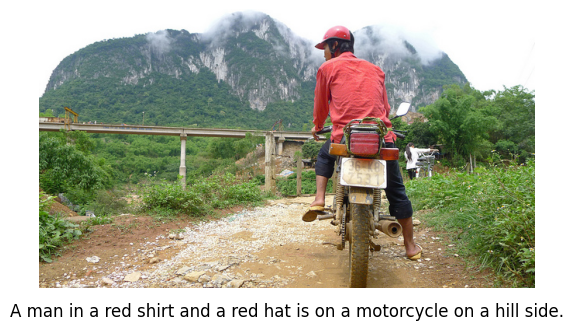

In [13]:
idx = 0
image = Image.open(train_df.image[idx])
caption = train_df.caption[idx]
encoded = train_dataset[idx]['caption']
decoded = vocab.decode(encoded.tolist())
print(f'Real: {caption}')
print(f'encoded: {encoded}')
print(f'decoded: {decoded}')

show_sample(image, caption)


## Model and Acrchiture

In this section, we will create our encoder-decoder model for the task at hand. The encoder-decoder model for image captioning consists of two main components: an encoder and a decoder.

* **Encoder:**
    The encoder processes the input image and encodes it into a fixed-length vector representation, often called the "image feature vector" or "image embedding." This is typically achieved using a convolutional neural network (CNN), such as VGG or ResNet. The CNN takes the raw image as input and applies a series of convolutional and pooling layers to extract meaningful visual features. The output of the encoder is a condensed representation of the image, capturing its salient features.

* **Decoder:**
    The decoder takes the image embedding generated by the encoder and generates a descriptive caption for the image. It is usually implemented using a recurrent neural network (RNN), such as a long short-term memory (LSTM) or a gated recurrent unit (GRU). The decoder RNN can receives the image embedding as its initial hidden state or feature vector as input and generates words one at a time. At each time step, the decoder predicts the next word in the caption based on its previous hidden state and the previously generated words. This process continues until an end-of-sentence token is generated or a predefined maximum caption length is reached.

During training, the model is provided with pairs of images and their corresponding captions. The encoder processes the images, and the decoder is trained to generate captions that match the ground truth captions. This training is typically done using techniques like teacher forcing, where the model is fed the correct previous word as input during training.

At inference time, the encoder-decoder model is used to generate captions for new images. The encoder processes the image to obtain the image embedding, and the decoder generates the caption word by word based on the image embedding and its previous predictions.

We will provide more implementation details in each subsequent parts.


### Encoder

In the encoder model, we will utilize transfer learning techniques by employing a pretrained model for a classification task. We will remove the classification head of the pretrained model and introduce a new representation head that condenses the feature map of the CNN network. Additionally, we will freeze all layers of the CNN model except for the added representation head.

Useful links:

* [ Transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)


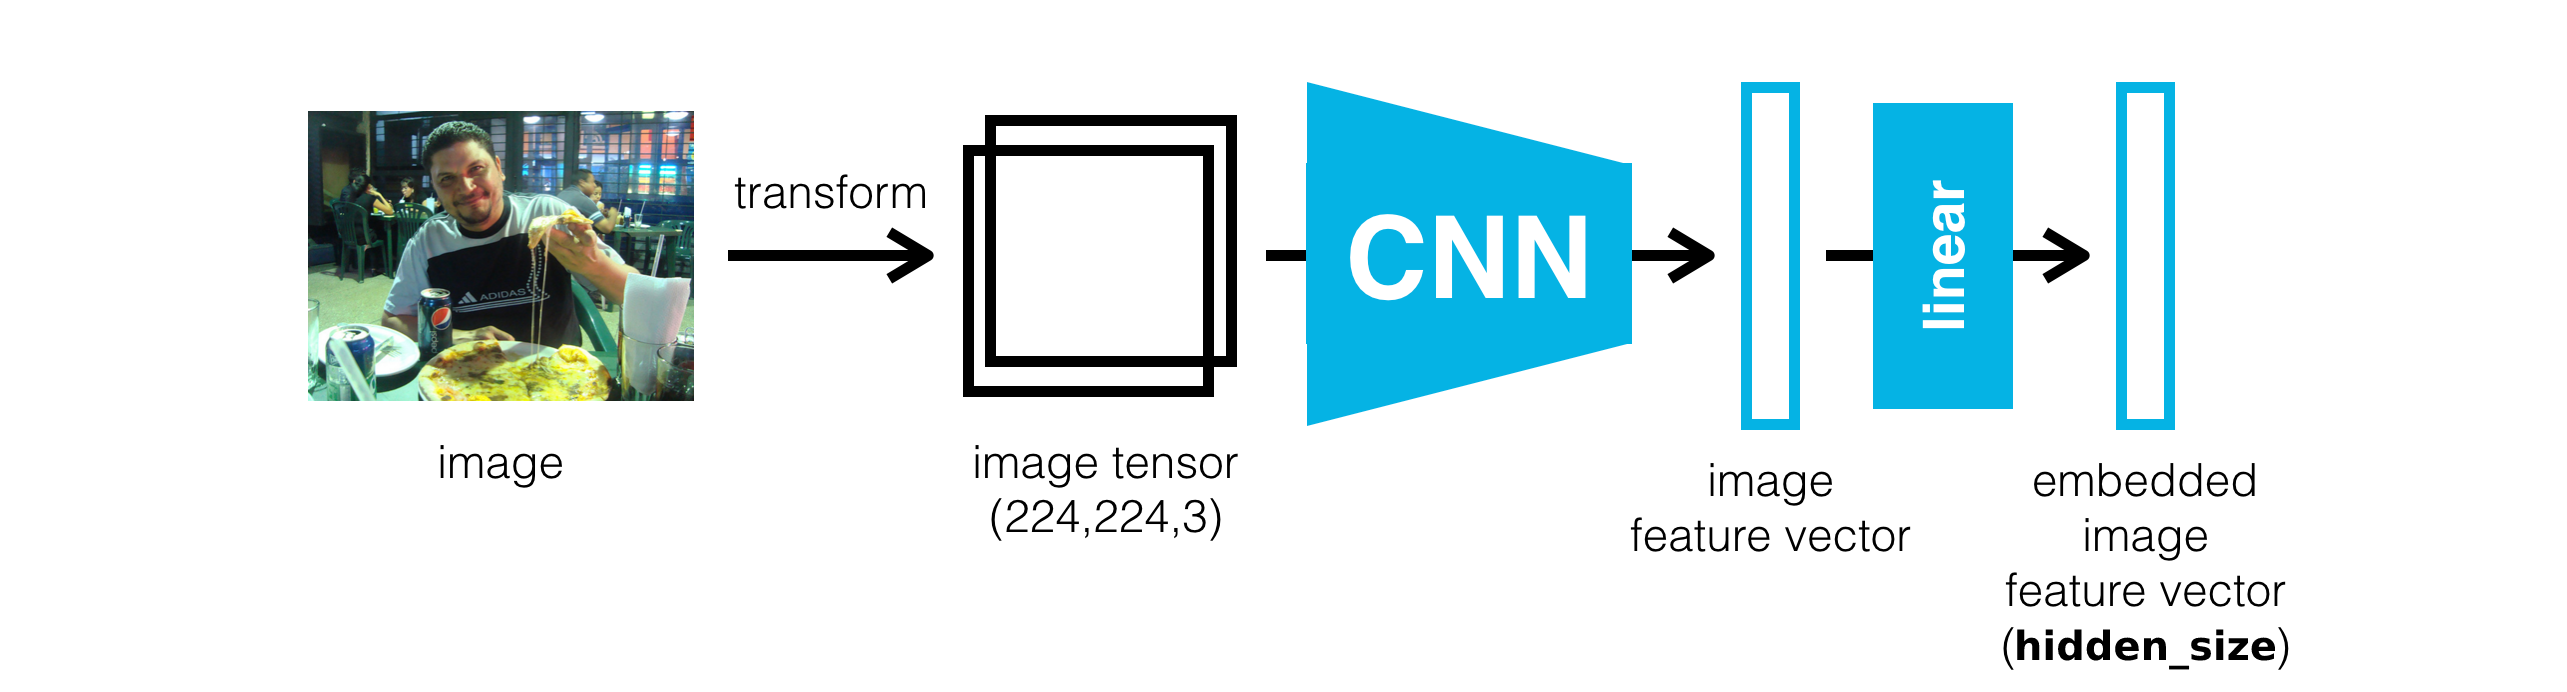

In the cell below, please complete the necessary sections, and feel free to experiment with different pretrained models.

In [14]:
class Encoder(nn.Module):
    """
    Encoder model that utilizes transfer learning.
    """

    def __init__(self, embed_size):
        """
        Initializes the Encoder class.

        Args:
            embed_size (int): The desired size of the image embedding.

        """
        super(Encoder, self).__init__()

        # Load a pretrained model
        net = models.resnet50(pretrained=True)

        # Freeze all the parameters in the net model
        for p in net.parameters():
            p.requires_grad = False

        # Extract the feature extraction layers from the net model
        modules = list(net.children())[:-1]

        # Create a sequential module using the feature extraction layers
        self.net = nn.Sequential(*modules)

        # Linear layer to condense the feature map into the desired embedding size
        self.embed = nn.Linear(net.fc.in_features, embed_size)

    def forward(self, images):
        """
        Forward propagation through the encoder.

        Args:
            images: Input images to be encoded.

        Returns:
            features: Encoded image features.
        """
        # ================== TODO ==================
        # Pass the images through the net model to extract features
        features = self.net(images)

        # Reshape the features to be of shape (batch_size, -1)
        features = features.view(features.size(0), -1)

        # Pass the features through the embed layer to get the desired embedding size
        features = self.embed(features)
        # ================== END ===================
        return features

### Decoder

In the encoder model, we feed the encoded features from the encoder as well as the encoded captions to the model. The feature vector from the encoder can be employed in different ways. One method is to use it as the initial hidden state, while another method involves concatenating the feature vector with the input embedding vector to generate subsequent words of the sentence.

Our architecture is illustrated in the diagram below.

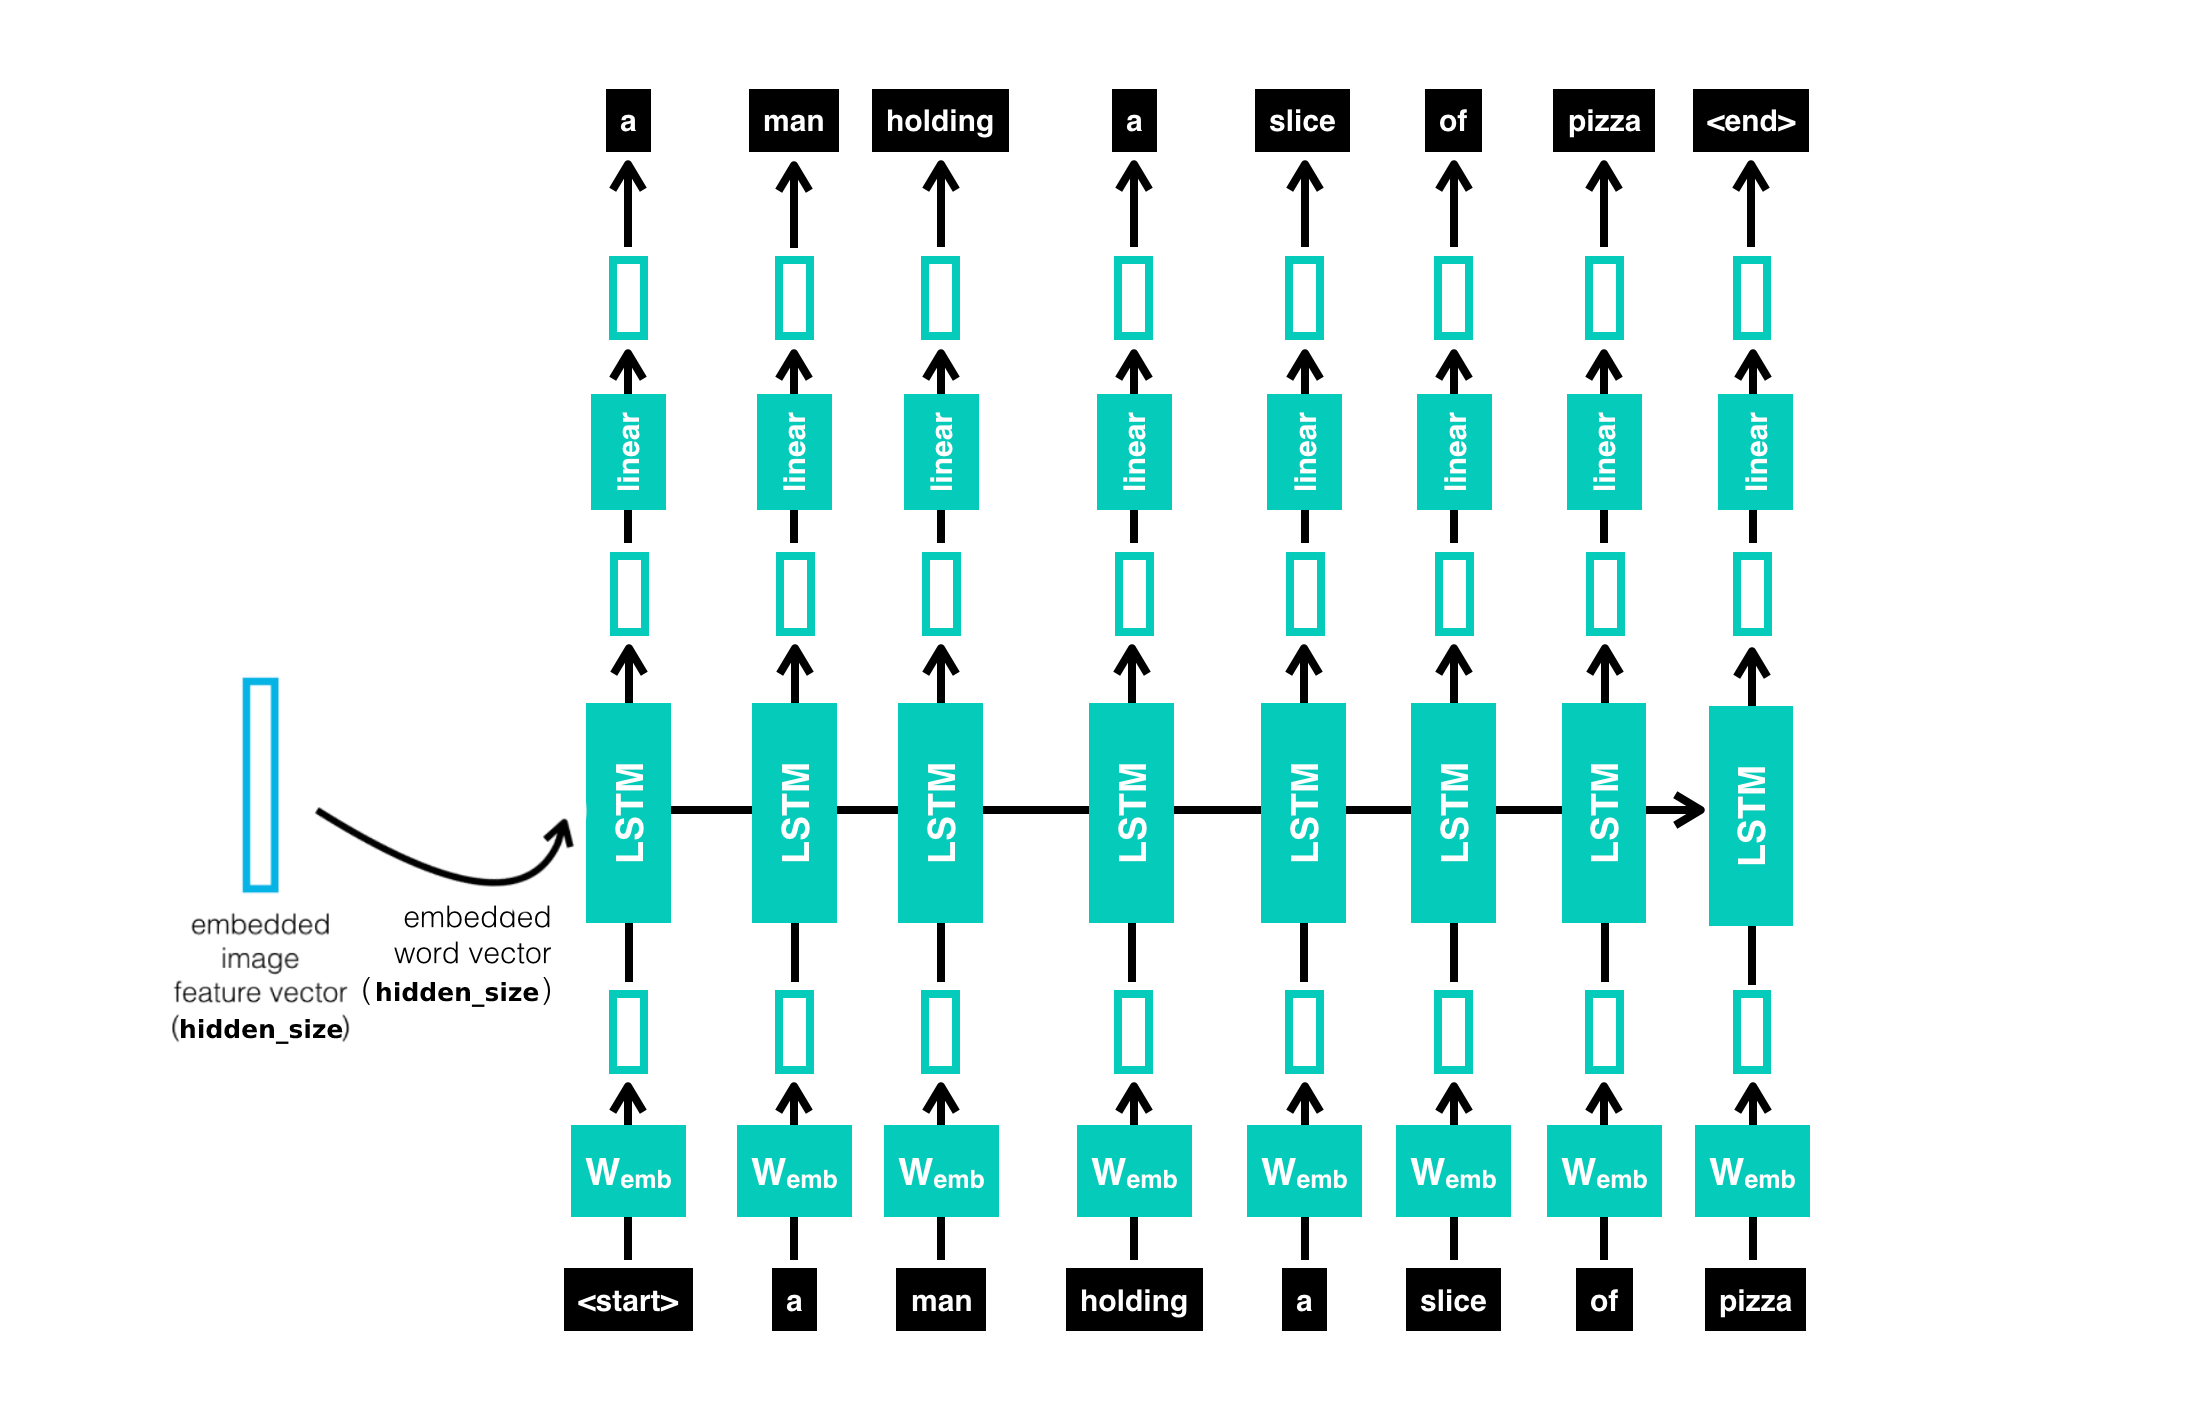

You must implement the architecture of the encoder model. One simple example such as above picture could be:

*    An embedding layer.
*    A LSTM (Long Short-Term Memory) layer.
*    A linear layer.

Feel free to implement different architectures using LSTM or GRU (Gated Recurrent Unit) based on your requirements and preferences.Additionally, the Encoder module should have two methods named `init_hidden` and `generate`.

The `init_hidden` method is used to initialize the first hidden state for the RNN. This hidden state is typically a tensor with appropriate dimensions based on the RNN architecture being used.

The `generate` method is used during test time for generating a caption for new images. It takes the encoded image features as input and generates words one at a time until the `<END>` token is generated or a maximum caption length is reached.

Useful links:

*   [Embbeding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
*   [GRU layer](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
*   [LSTM layer](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)



In [15]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    """
    Decoder module for generating captions based on image features.
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        """
        Initializes the Decoder module.

        Args:
            embed_size (int): Size of the word embeddings.
            hidden_size (int): Size of the hidden state of the LSTM.
            vocab_size (int): Size of the vocabulary.
            num_layers (int, optional): Number of LSTM layers. Defaults to 2.
        """
        super(Decoder, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # ================== TODO ==================
        # Define an embedding layer to convert word indices to embeddings
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Define an LSTM layer to generate captions
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)

        # Define a linear layer to convert LSTM outputs to vocabulary scores
        self.linear = nn.Linear(hidden_size, vocab_size)


        # ================== END ==================

    def forward(self, features, captions):
        """
        Performs the forward pass of the Decoder module.

        Args:
            features (torch.Tensor): Image features.
            captions (torch.Tensor): Caption inputs.

        Returns:
            torch.Tensor: Caption outputs.
        """
        # ================== TODO ==================
        # Embed the captions
        embeddings = self.embedding(captions)

        # Pass the caption embeddings through the LSTM layer
        lstm_out, _ = self.lstm(embeddings)

        # Pass the LSTM outputs through the linear layer
        outputs = self.linear(lstm_out)

        # ================== END ==================

        return outputs

    def generate(self, inputs, max_len):
        """
        Generates captions based on the given inputs.

        Args:
            inputs (torch.Tensor): Input tensor for caption generation.
            max_len (int): Maximum length of the generated caption.

        Returns:
            list: List of generated caption indices.
        """
        outputs = []
        states = None

        # ================== TODO ==================
        for i in range(max_len):
          # Pass the inputs through the LSTM layer
          lstm_out, states = self.lstm(inputs, states)

          # Pass the LSTM outputs through the linear layer
          output = self.linear(lstm_out.squeeze(1))

          # Get the predicted word index
          _, predicted = output.max(1)

          # Append the predicted word index to the outputs list
          outputs.append(predicted.item())

          # Update the inputs for the next time step
          inputs = self.embedding(predicted)
          inputs = inputs.unsqueeze(1)

        # ================== END ==================

        return outputs

    def init_hidden(self, features):
        """
        Initializes the hidden state of the LSTM layer with the image features.

        Args:
            features (torch.Tensor): Image features.

        Returns:
            tuple: Initial hidden state of the LSTM layer.
        """
        hidden = None
        # ================== TODO ==================

        # Expand the image features to match the dimensions of the LSTM hidden state
        hidden = features.unsqueeze(0).expand(self.num_layers, -1, -1).contiguous()

        # Initialize the cell state with zeros
        cell = torch.zeros_like(hidden)

        # ================== END ==================
        return hidden


### Encoder-Decoder (Image Captioner)

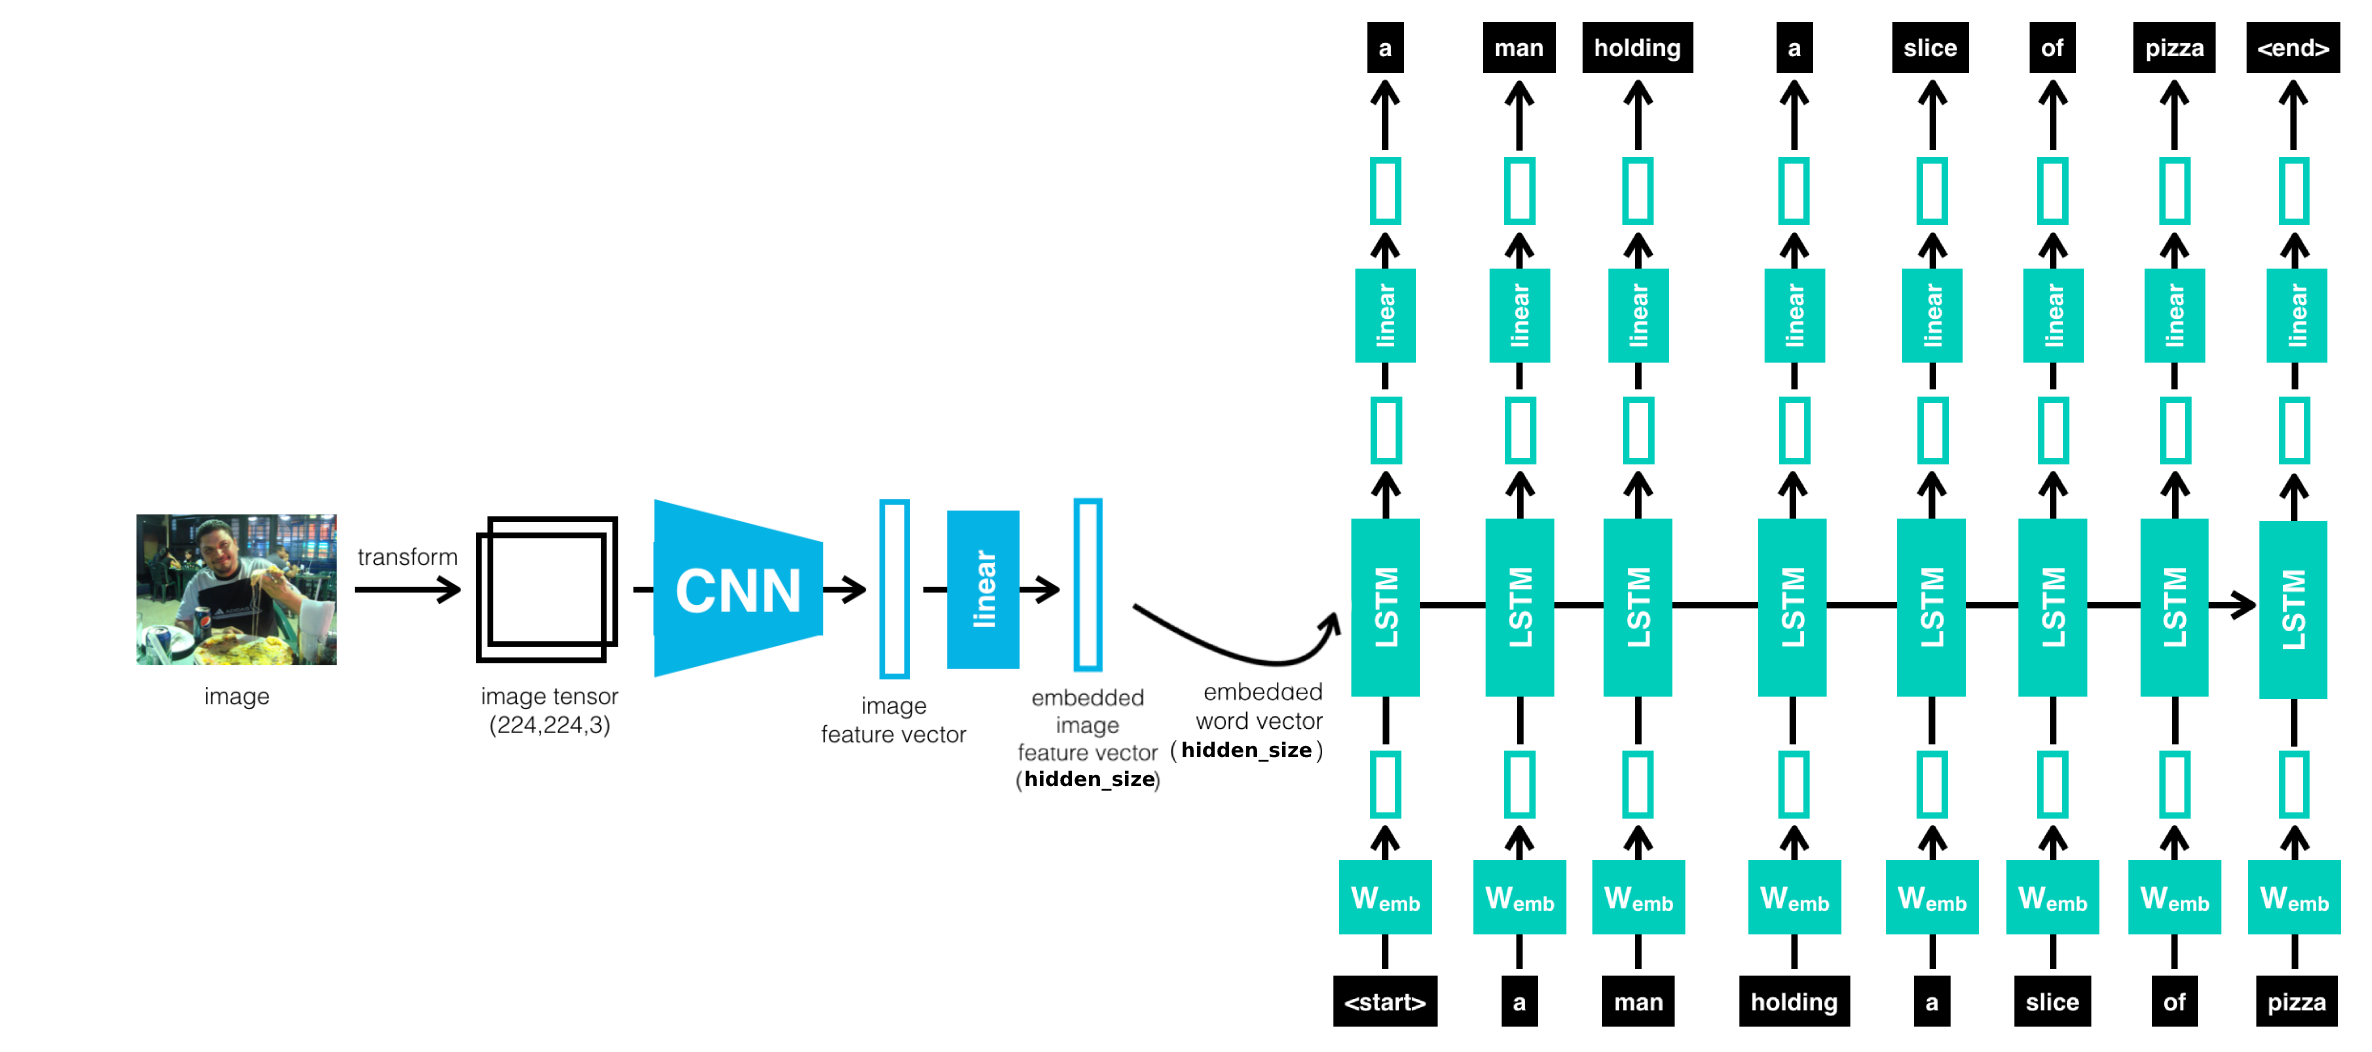

In the last step, we will combine the encoder with the decoder to create our final model. Please complete this model in the cell below.

Note that the `predict` method generates a caption for a single input image. It takes a single input image and the maximum length of the generated caption as inputs. The image is passed through the encoder to obtain the image embedding. The image embedding is then fed to the decoder to generate the caption word by word until the maximum length is reached or the `<END>` token is generated. The generated output is decoded using the vocabulary to obtain the caption as a string. Finally, the decoded caption is returned.

In [25]:
class ImageCaptioner(nn.Module):
    """
    Image Captioning model that combines an Encoder and a Decoder.
    """

    def __init__(self, embed_size, hidden_size, vocab_size):
        """
        Initializes the ImageCaptioner model.

        Args:
            embed_size (int): Size of the image embedding.
            hidden_size (int): Size of the hidden state in the decoder.
            vocab_size (int): Size of the vocabulary.
        """
        super(ImageCaptioner, self).__init__()
        # ================== TODO ==================

        # Define the encoder
        self.encoder = Encoder(embed_size)

        # Define the decoder
        self.decoder = Decoder(embed_size, hidden_size, vocab_size)

        # ================== END ==================

    def forward(self, images, captions):
        """
        Forward propagation through the ImageCaptioner model.

        Args:
            images (tensor): Batch of input images.
            captions (tensor): Batch of input captions.

        Returns:
            output (tensor): Output from the decoder model.
        """
        # ================== TODO ==================

        # Print the shape of the images tensor
       ##print(f"images.shape: {images.shape}")

        # Print the shape of the captions tensor
       ##print(f"captions.shape: {captions.shape}")

        # Encode the images using the encoder
        features = self.encoder(images)

        # Print the shape of the features tensor
       ##print(f"features.shape: {features.shape}")

        # Generate captions using the decoder
        output = self.decoder(features, captions)

        # Print the shape of the output tensor
       ##print(f"output.shape: {output.shape}")

        # ================== END ==================
        return output

    def predict(self, image, max_len=20):
        """
        Generates a caption for a single input image.

        Args:
            image (tensor): Single input image.
            max_len (int): Maximum length of the generated caption.

        Returns:
            decoded_output (str): Decoded caption.
        """
        # ================== TODO ==================

        # Pass the image through the encoder to obtain its embedding
        image_embedding = self.encoder(image.unsqueeze(0))

        # Generate a caption using the decoder
        output = self.decoder.generate(image_embedding.unsqueeze(0), max_len)

        # Decode the generated caption using the vocabulary
        decoded_output = vocab.decode(output)

        # ================== END ==================
        image_embedding = self.encoder(image.unsqueeze(0))
        output = self.decoder.generate(image_embedding.unsqueeze(0), max_len)
        decoded_output = vocab.decode(output)
        return decoded_output

## Train and Validation

### Hyperparameter


Below, we will define the hyperparameters for our model. Here are the explanations for each parameter:

- `learning_rate`: The learning rate used for the optimizer to update the model parameters during training.
- `batch_size`: The number of samples to be processed in each training batch.
- `embed_size`: The size of the image embedding vector.
- `hidden_size`: The size of the hidden state in the decoder model.
- `num_epochs`: The total number of training epochs to run.
- `val_every`: Determines how often the model's performance will be evaluated on the validation set during training.
- `print_every`: Controls the frequency at which the training progress is printed, typically after processing a certain number of batches.
- `vocab_size`: The size of the vocabulary, which is the number of unique words in the dataset.
- `device`: The device to be used for training and inference. It is set to use the GPU ("cuda") if available, otherwise it will use the CPU ("cpu").

By adjusting the learning rate at different stages of the training process, it is possible to accelerate the convergence of the model and achieve better optimization. To achieve this, you can utilize learning rate schedulers such as `ReduceLROnPlateau`.

Useful links:

* [Optimizers and Schedulers](https://pytorch.org/docs/stable/optim.html)

In [147]:
# ================== TODO ==================
learning_rate = 0.001
batch_size = 64
embed_size = 256
hidden_size = 512
num_epochs = 5
val_every = 100
print_every = 50
# ================== END ==================
vocab_size = len(vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Loaders



In this part, we will create the data loaders for the training and validation datasets. Since the sentences in the dataset have variable lengths, we need to pad them before passing them to the model.

The `collate_fn` function is defined to process a batch of samples. It stacks the image tensors from each sample and pads the caption sequences to have the same length using the `pad_sequence` function.

Useful links:
* [Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
* [torch.utils.data](https://pytorch.org/docs/stable/data.html)

In [148]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """
    Collate function used in the data loader to process a batch of samples.

    Args:
        batch (list): List of samples in a batch.

    Returns:
        images (tensor): Stacked tensor of image samples.
        captions (tensor): Padded tensor of caption sequences.
    """
    images = torch.stack([item['image'] for item in batch])
    captions = [item['caption'] for item in batch]
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab('<PAD>'))
    return images, captions

# ================== TODO ==================
# Create the train data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Create the validation data loader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
# ================== END ===================

### Loss Function

In order to effectively guide and train our model, it is necessary to define a loss function that takes target captions and generated captions from the decoder model as input and calculates the loss. This loss calculation will be implemented in the `compute_loss` function. PyTorch provides pre-defined loss functions such as CrossEntropyLoss that can be used for this purpose. However, it is crucial to exclude the added `<PAD>` tokens before computing the loss, as these tokens are not part of the true captions, Including them in the loss calculation may potentially diminish the accuracy of the model.

Useful links:

* [Cross Entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [149]:
# ================== TODO ==================
criterion = nn.CrossEntropyLoss(ignore_index=vocab('<PAD>'))
# ================== END ===================

def compute_loss(preds, target):
    """
    Compute the loss using the some loss function.

    Args:
        preds (tensor): Predicted logits from the model.
        target (tensor): Target labels.

    Returns:
        loss (tensor): Computed loss.
    """
    # ================== TODO ==================
    # Note: you must remove pad tokens before caculating loss!
    # ==========================================
    # Reshape the predictions and targets
    preds = preds.view(-1, preds.shape[-1])
    target = target.view(-1)

    # Compute the loss while ignoring <PAD> tokens
    loss = criterion(preds, target)
    # ================== END ===================
    return loss

### Evaluation Metrics

In this section, we will define metrics that provide an indication of our model's accuracy in generating captions. Here, we introduce the `compute_metrics` function, which takes target captions and generated captions as inputs and returns a dictionary object with keys `bleu` and `perplexity`. These keys represent the BLEU score and perplexity metrics, respectively.

Useful links:
* [Evaluation of text generation models](https://towardsdatascience.com/how-to-evaluate-text-generation-models-metrics-for-automatic-evaluation-of-nlp-models-e1c251b04ec1)
* [blue score](https://torchmetrics.readthedocs.io/en/stable/text/bleu_score.html)
* [perplexity](https://torchmetrics.readthedocs.io/en/stable/text/perplexity.html)


In [180]:
from torchmetrics import BLEUScore, Perplexity

perp = Perplexity(ignore_index=vocab('<PAD>')).to(device)
bleu = BLEUScore().to(device)

def compute_metrics(preds, target):
    """
    Compute evaluation metrics including perplexity.

    Args:
        preds (tensor): Predicted logits from the model.
        target (tensor): Target labels.

    Returns:
        result (dict): Dictionary containing computed evaluation metrics.
    """
    result = {}
    # ================== TODO ==================
    # Note: 1. you must remove pad tokens.
    #       2. use vocab.decode() function if there is need to decode samples.
    # ==========================================


    # Compute the perplexity while ignoring <PAD> tokens
    result['perplexity'] = perp(preds, target)

    # Convert the predicted logits to predicted captions
    pred_captions = torch.argmax(preds, dim=-1)
    #print(pred_captions.shape)

    # Decode the predicted and target captions
    pred_captions = [' '.join([vocab.decode([int(x) for x in p])]) for p in pred_captions]
    #print(pred_captions)

    target_captions = [' '.join([vocab.decode([int(x) for x in t])]) for t in target]
    #print(target_captions)

    # Compute the BLEU score
    # define the padding token
    padding_token = '<PAD>'

    # remove padding tokens from the predicted captions
    pred_captions = [' '.join([token for token in sentence.split() if token != padding_token]) for sentence in pred_captions]
    print(pred_captions)

    # remove padding tokens from the target captions
    target_captions = [' '.join([token for token in sentence.split() if token != padding_token]) for sentence in target_captions]
    # Wrap each target caption in an additional list
    target_captions = [[caption] for caption in target_captions]
    print(target_captions)

    # calculate the BLEU score
    result['bleu'] = bleu(pred_captions, target_captions)

    # ================== END ===================
    return result


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `Perplexity` from `torchmetrics` was deprecated and will be removed in 2.0. Import `Perplexity` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `BLEUScore` from `torchmetrics` was deprecated and will be removed in 2.0. Import `BLEUScore` from `torchmetrics.text` instead.
  _future_warning(


### Create model and optimizer

Prior to commencing the training process, we define our model and optimizer. We pass the model's trainable parameters to the optimizer object. It's important to note that parameters for which we set `requires_grad=False` (as mentioned earlier) will not be updated by the optimizer. In this case, we are using the Adam optimizer, but you have the flexibility to modify it or provide desired arguments as needed.

Useful links:
* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [181]:
from torch import optim

model = ImageCaptioner(embed_size, hidden_size, vocab_size)  # Create an instance of the ImageCaptioner model
model.to(device)  # Move the model to the specified device (e.g., GPU)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Create an Adam optimizer for the model parameters with the specified learning rate



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train Loop

Now is the moment to train our model. Here we introduce the training loop for the training process, which includes evaluations and logging based on predefined parameters `val_every` and `print_every`. We store the average validation and training losses for future interpretation.

Useful links:

* [Training loop](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)

In [182]:
train_loss = []  # List to store training loss
val_loss = []  # List to store validation loss
tmp_loss = []  # List to store temporary loss values

model.train()  # Set the model in training mode

# tqdm is used to display progress bars
bar = tqdm(desc="Steps", total=len(train_loader) * num_epochs)  # Progress bar for training steps
step = 0  # Counter for the current step

# Loop through each epoch
for epoch in range(num_epochs):
    # Loop through each batch in the training data loader
    for batch in train_loader:
        bar.update()  # Update progress bar
        bar.set_postfix({'Epoch': f'{epoch+1}/{num_epochs}'})  # Update epoch display in progress bar
        step += 1

        # ================== TODO ==================

        # Get the images and captions from the batch
        images, captions = batch

        # Move the images and captions to the device
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Forward pass: compute predicted captions by passing images to the model
        preds = model(images, captions)

        # Compute the loss between predicted and target captions
        loss = compute_loss(preds, captions)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()
        # ================== END ===================

        tmp_loss.append(loss.item())  # Store the loss value in the temporary list

        if step % print_every == 1:
            # Print the loss , bleu and perplexity metrics for every `print_every` steps
            metrics = compute_metrics(preds, captions)
            print(f'Epoch: {epoch} , Step: {step}, Loss: {loss.item()}, Bleu: {metrics["bleu"]} Perplexity: {metrics["perplexity"]}')

        if step % val_every == 0:
            model.eval()  # Set the model in evaluation mode
            with torch.no_grad():
                print('\n===================== Validation =====================')

                loss = 0
                p_metric = 0
                b_metric = 0

                # Loop through each batch in the validation data loader
                for v_batch in tqdm(val_loader, desc='Val steps'):
                    outputs = model(images, captions)  # Forward pass: compute model outputs
                    loss += compute_loss(outputs, captions).item()  # Compute the loss
                    metrics = compute_metrics(outputs, captions)  # compute metrics
                    p_metric += metrics["perplexity"]  # Compute the perplexity metric
                    b_metric += metrics["bleu"] # Compute the bleu metric
                loss /= len(val_loader)  # Calculate the average validation loss
                p_metric /= len(val_loader)  # Calculate the average perplexity metric
                train_loss.append(np.mean(tmp_loss))  # Compute the mean training loss and add it to the list
                val_loss.append(loss)  # Add the validation loss to the list
                tmp_loss.clear()  # Clear the temporary loss list for the next epoch
                print(f"Validation: Loss:{loss}, Perplexity: {p_metric}")
                print('======================================================\n')
            model.train()  # Set the model back to training mode


Steps:   0%|          | 0/9245 [00:00<?, ?it/s]

['vietnamese kitchen towering highly using av cotton highly av av unloads brownish highly kayak av yells attack attack attack attack attack attack attack attack attack attack attack attack', 'vietnamese kitchen riverboat head backdrop av altered around av av unloads barrels highly twigs like sweet attack attack attack attack attack attack attack attack attack attack attack attack', 'vietnamese highly pizzeria slats backdrop av 10 pull av av unloads yells attack into like sweet attack attack attack attack attack attack attack attack attack attack attack attack', 'vietnamese highly sweet gorilla sweet av altered displays altered av sweet yells attack attack like attack attack attack attack attack attack attack attack attack attack attack attack attack', 'vietnamese highly chat av sweet snowboarder motorola pull altered maneuvering sweet sure ears attack attack attack attack attack attack attack attack attack attack attack attack attack attack attack', 'vietnamese head angels av penned ye

KeyboardInterrupt: ignored

The training and validation loss provide insights into the model's performance during training, allowing us to interpret aspects such as overfitting or underfitting. In the following section, we will plot the training and validation loss obtained throughout the training process.

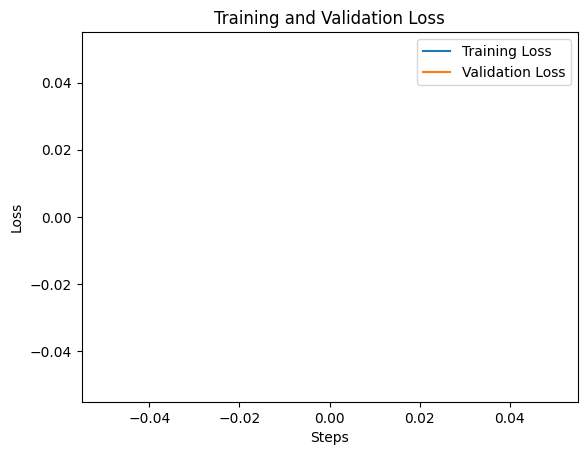

In [183]:
from matplotlib.pylab import plt

# Generate a sequence of integers to represent the epoch numbers
steps = range(1, len(train_loss)+1)

# Plot and label the training and validation loss values
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')


# Display the plot
plt.legend(loc='best')
plt.show()

## Test Time!

No further explanation is required in this context, so you can simply press `Shift + Enter`.

In [184]:
def inference(count=6, cols=3):
    images , captions = [], []  # Lists to store generated images and captions

    model.eval()  # Set the model in evaluation mode
    with torch.no_grad():
        for i in range(count):
            idx = np.random.randint(0, len(test_dataset))  # Randomly select an index from the test dataset
            sample = test_dataset[idx]  # Get the sample at the selected index
            caption = model.predict(sample['image'].to(device), max_len=15)  # Generate a caption for the sample image
            images.append(sample['original'])  # Append the original image to the list
            captions.append(caption)  # Append the generated caption to the list

    show_sample(images, captions, cols=cols)  # Display the generated images with their captions in a grid layout


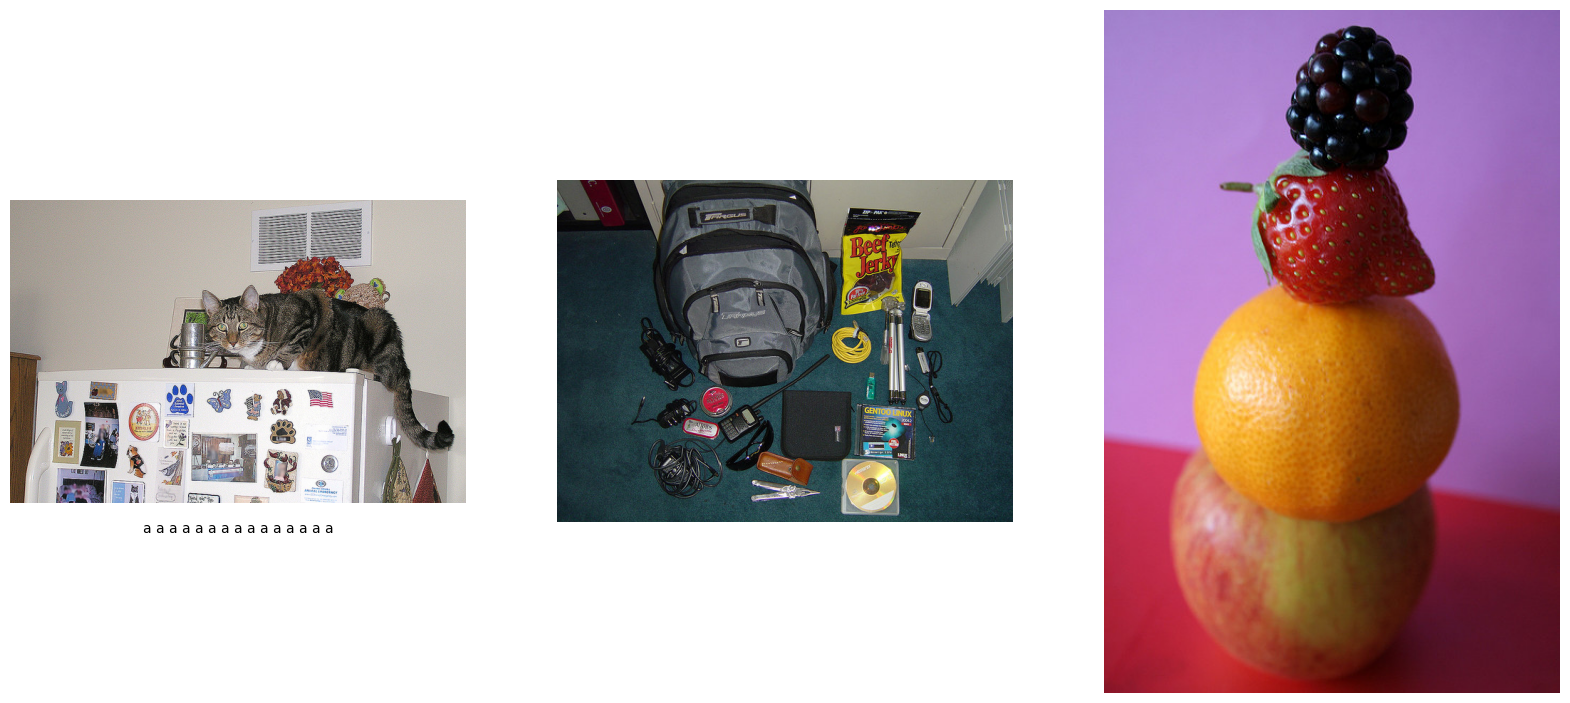

In [185]:
inference(3)